In [69]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D, Flatten, Reshape, Lambda, Dot, Concatenate, Permute, Input
from keras.optimizers import Adam
from keras import backend as K

# matplotlib settings
plt.style.use('ggplot')
%matplotlib inline

# Register converters to use pandas datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [70]:
data= pd.read_excel('Sample - Superstore.xls')

In [71]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit',
       'unnamed:_21', 'furniture', 'office_supplies', 'technology',
       'unnamed:_25', 'unnamed:_26', 'average_demand', 'furniture.1',
       'office_supplies.1', 'technology.1', 'unnamed:_31', 'furniture.2',
       'office_supplies.2', 'technology.2', 'unnamed:_35',
       'average_volatility', 'furniture.3', 'office_supplies.3',
       'technology.3', 'unnamed:_40', 'max', 'furniture.4',
       'office_supplies.4', 'technology.4', 'unnamed:_45', 'min',
       'furniture.5', 'office_supplies.5', 'technology.5'],
      dtype='object')

In [72]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

In [73]:
furniture = furniture.groupby('order_date')[['sales', 'quantity']].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [74]:
#Set index
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

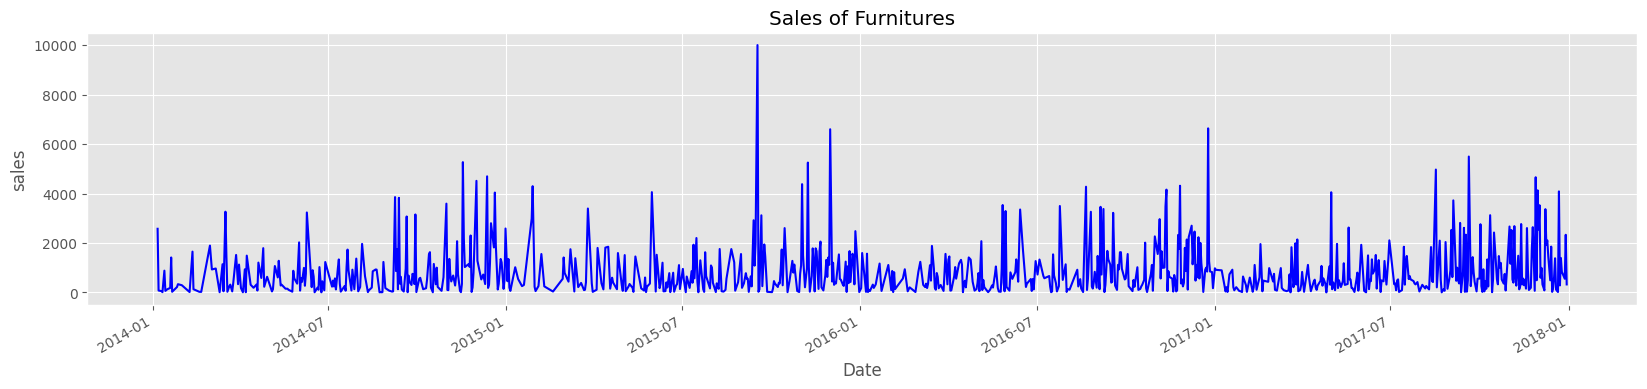

In [75]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [76]:
# Using averages daily sales value - set start of the month as index
df = furniture[['sales', 'quantity']].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

In [77]:
def performance(y_true, y_pred):
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [78]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [80]:
df

,sales,quantity
order_date,,
2014-01-01,480.194231,5.384615
2014-02-01,367.931600,4.600000
2014-03-01,857.291529,7.705882
2014-04-01,567.488357,5.785714
2014-05-01,432.049188,6.062500
2014-06-01,695.059242,6.421053
2014-07-01,601.169500,6.333333
2014-08-01,457.521656,6.687500
2014-09-01,992.353367,8.666667


*STACKED* LSTM

In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping

# Assuming 'df' contains your data
# Selecting the columns 'Close' and 'Volume'
data = df[['sales']]

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
# Function to create the training dataset
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        b = [dataset[i + j, 0] for j in range(look_back, look_back + look_forward)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# Dividimos los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.6)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
# Creating the training dataset
look_back = 2
look_forward = 2
X_train, y_train = create_dataset(train, look_back, look_forward)

# Creating the testing dataset
X_test, y_test = create_dataset(test, look_back, look_forward)

# Reshaping the data for LSTM# Reshaping the data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [82]:
X_train

array([[[0.10491986],
        [0.00941215]],

       [[0.00941215],
        [0.42573631]],

       [[0.42573631],
        [0.17918555]],

       [[0.17918555],
        [0.06396035]],

       [[0.06396035],
        [0.2877168 ]],

       [[0.2877168 ],
        [0.20783987]],

       [[0.20783987],
        [0.08563111]],

       [[0.08563111],
        [0.5406405 ]],

       [[0.5406405 ],
        [0.35063521]],

       [[0.35063521],
        [0.53031928]],

       [[0.53031928],
        [1.        ]],

       [[1.        ],
        [0.52870878]],

       [[0.52870878],
        [0.14082284]],

       [[0.14082284],
        [0.36103226]],

       [[0.36103226],
        [0.3819493 ]],

       [[0.3819493 ],
        [0.22811092]],

       [[0.22811092],
        [0.06099659]],

       [[0.06099659],
        [0.30868536]],

       [[0.30868536],
        [0.20889694]],

       [[0.20889694],
        [0.87280601]],

       [[0.87280601],
        [0.23490289]],

       [[0.23490289],
        [0.7

In [83]:
y_train

array([[0.42573631, 0.17918555],
       [0.17918555, 0.06396035],
       [0.06396035, 0.2877168 ],
       [0.2877168 , 0.20783987],
       [0.20783987, 0.08563111],
       [0.08563111, 0.5406405 ],
       [0.5406405 , 0.35063521],
       [0.35063521, 0.53031928],
       [0.53031928, 1.        ],
       [1.        , 0.52870878],
       [0.52870878, 0.14082284],
       [0.14082284, 0.36103226],
       [0.36103226, 0.3819493 ],
       [0.3819493 , 0.22811092],
       [0.22811092, 0.06099659],
       [0.06099659, 0.30868536],
       [0.30868536, 0.20889694],
       [0.20889694, 0.87280601],
       [0.87280601, 0.23490289],
       [0.23490289, 0.79105777],
       [0.79105777, 0.58913514],
       [0.58913514, 0.12873126],
       [0.12873126, 0.        ],
       [0.        , 0.21499156]])

In [84]:
# Definimos el modelo
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(look_forward)) #aquí me va a ir a ver cuántos días estoy prediciendo hacia delante para poner ese número de neuronas
model.compile(optimizer='adam', loss='mean_squared_error')

#vamos a tener más modelos proqie tenemos más capas y para cada una va a ir probando las diferentes alternativas

from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=50)

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=[es]) #batch 16 y epoch 50


# Hacemos las predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


# Inverting the predictions
scaler_close = MinMaxScaler()  # Create a new instance
scaler_close.fit(df[['sales']])  # Fit the scaler with appropriate columns

# Ensure the predictions and targets have the correct shape
train_predict = train_predict.reshape(-1, 1)  # Reshape to match (n_samples, 1)
y_train = y_train.reshape(-1, 1)  # Reshape to match (n_samples, 1)
test_predict = test_predict.reshape(-1, 1)  # Reshape to match (n_samples, 1)
y_test = y_test.reshape(-1, 1)  # Reshape to match (n_samples, 1)


# Perform inverse transformation
train_predict = scaler_close.inverse_transform(train_predict)
y_train = scaler_close.inverse_transform(y_train)
test_predict = scaler_close.inverse_transform(test_predict)
y_test = scaler_close.inverse_transform(y_test)



Epoch 1/50
2/2 [==============================] - 5s 17ms/step - loss: 0.1878
Epoch 2/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1738
Epoch 3/50
2/2 [==============================] - 0s 15ms/step - loss: 0.1612
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.1490
Epoch 5/50
2/2 [==============================] - 0s 14ms/step - loss: 0.1359
Epoch 6/50
2/2 [==============================] - 0s 15ms/step - loss: 0.1261
Epoch 7/50
2/2 [==============================] - 0s 10ms/step - loss: 0.1141
Epoch 8/50
2/2 [==============================] - 0s 10ms/step - loss: 0.1054
Epoch 9/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0953
Epoch 10/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0876
Epoch 11/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0815
Epoch 12/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0761
Epoch 13/50
2/2 [==============================] - 0s 11ms/st

1/1 [==============================] - 0s 22ms/step


In [85]:
# Definir las funciones para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular las métricas para el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train[:,0], train_predict[:,0]))
mape_train = mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])
mae_train = mean_absolute_error(y_train[:,0], train_predict[:,0])

# Calcular las métricas para el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test[:,0], test_predict[:,0]))
mape_test = mean_absolute_percentage_error(y_test[:,0], test_predict[:,0])
mae_test = mean_absolute_error(y_test[:,0], test_predict[:,0])

# Crear un DataFrame para visualizar los resultados
results = pd.DataFrame({'Set': ['Entrenamiento', 'Prueba'],
                        'RMSE': [rmse_train, rmse_test],
                        'MAPE': [mape_train, mape_test],
                        'MAE': [mae_train, mae_test]})
print(results)

             Set        RMSE       MAPE         MAE
0  Entrenamiento  304.413709  35.335989  241.740893
1         Prueba  311.827512  33.745188  255.887753
